In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import pandas as pd
import os
import numpy as np
from collections import defaultdict
from scipy.spatial.distance import cdist
import difflib
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy import sparse
import random
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")
import ast
from scipy.spatial.distance import cosine, euclidean, hamming
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from time import time
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv(r"datasets/data_by_artist.csv")
data.head()

,mode,count,acousticness,artists,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,9,0.590111,"""Cats"" 1981 Original London Cast",0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5
1,1,26,0.862538,"""Cats"" 1983 Broadway Cast",0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5
2,1,7,0.856571,"""Fiddler On The Roof” Motion Picture Chorus",0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0
3,1,27,0.884926,"""Fiddler On The Roof” Motion Picture Orchestra",0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0
4,1,7,0.510714,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5


In [3]:
artist_data = data[['valence','artists','count','popularity']]
artist_data.to_csv('artist_data.csv')

In [4]:
def PCA_algorithm(data):
    num_datatypes = data.select_dtypes(np.number)      

    pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
    song_embedding = pca_pipeline.fit_transform(num_datatypes)
    return song_embedding

In [51]:
def KMeans_with_PCA_algorithm(song_embedding):
    kmeans_pca = KMeans(n_clusters = 20, init = 'k-means++', random_state=42)     
    label = kmeans_pca.fit(song_embedding)
    centroids = kmeans_pca.cluster_centers_
    return label,centroids

In [54]:
def filter_based_on_segment(df_segm_pca_kmeans,segment_val):    
    #get list of songs with above song id
    #print(df_segm_pca_kmeans[df_segm_pca_kmeans['Segment K-means PCA']==segment_val].values)
    
    filtered_data_per_segment = df_segm_pca_kmeans[df_segm_pca_kmeans['Segment K-means PCA']==segment_val][['artists', 'valence','com1','com2','Segment K-means PCA']]

    #save to csv file
    filtered_data_per_segment.to_csv('filtered_data_per_segment_for_artists.csv')
    return filtered_data_per_segment

In [56]:
def filter_based_on_cluster_centroid(kmeans_pca,filtered_data_per_segment,segment_val,tracks):
    #calculate distance based on cluster centroid
    scaled_data = kmeans_pca.transform( filtered_data_per_segment[['com1','com2']])
    scaled_song_center = kmeans_pca.transform(kmeans_pca.cluster_centers_[segment_val].reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')

    #sort based on distance
    index = list(np.argsort(distances)[0])
    rec_songs = filtered_data_per_segment.iloc[index]
    
    #recommend based on segment data
    # rec_songs = rec_songs[~rec_songs['name'].isin(filtered_data_per_segment['name'])]
    return rec_songs

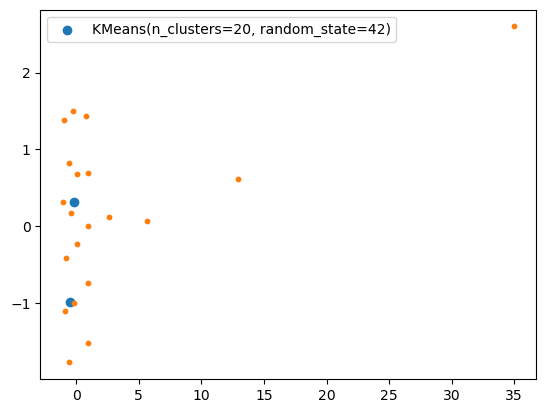

In [52]:
#Importing required modules
import matplotlib.pyplot as plt 
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np


df = PCA_algorithm(artist_data)
label,centroids = KMeans_with_PCA_algorithm(df)

#num_datatypes = data.select_dtypes(np.number)   
#pca = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
#df = pca.fit_transform(num_datatypes)

#kmeans = KMeans(n_clusters = 10, init = 'k-means++', random_state=42) 

#label = kmeans.fit_predict(df)
#centroids = kmeans.cluster_centers_
 
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
     plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 10)
plt.legend()
plt.show()

In [57]:
song_embedding = PCA_algorithm(artist_data)
kmeans_pca,centroids = KMeans_with_PCA_algorithm(song_embedding)

df_segm_pca_kmeans = pd.concat([artist_data.reset_index(drop=True), pd.DataFrame(song_embedding)],axis=1)
df_segm_pca_kmeans.columns.values[-2:] = ['com1','com2']
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

#get segment value of artist
artist = 'Frank Sinatra'
segment_val = df_segm_pca_kmeans[df_segm_pca_kmeans['artists'] == artist]['Segment K-means PCA'].values[0]

filtered_data_per_segment = filter_based_on_segment(df_segm_pca_kmeans,segment_val)   

rec_songs = filter_based_on_cluster_centroid(kmeans_pca,filtered_data_per_segment,segment_val,artist_data)

print(rec_songs)

                           artists   valence       com1      com2  \
12170        Johann Sebastian Bach  0.549525  12.976715  0.938996   
27610      Wolfgang Amadeus Mozart  0.324705  12.814141  0.000345   
3004                     Bob Dylan  0.549650  12.605713  0.941866   
4307                        Charlo  0.742842  12.924716  1.705046   
7426                 Elvis Presley  0.617856  13.338832  1.272733   
25487           The Rolling Stones  0.659161  12.373888  1.382649   
15380         Ludwig van Beethoven  0.256824  12.472344 -0.305528   
24342               The Beach Boys  0.629986  12.221201  1.240854   
14179              Lata Mangeshkar  0.647905  12.090485  1.271457   
7353               Ella Fitzgerald  0.397493  12.016990  0.270276   
18056        New York Philharmonic  0.220258  14.051841 -0.353598   
6010                   Dean Martin  0.474576  11.815525  0.570274   
12378                  Johnny Cash  0.672277  14.057666  1.529870   
8638               Frédéric Chopin

In [13]:
p = 0.02  # to randomly select 1% of the rows
df_playlist = pd.read_csv(r"test_dataset/spotify_dataset.csv", error_bad_lines=False, warn_bad_lines=False, skiprows=lambda i: i>0 and random.random() > p)
df_playlist.head()

,user_id,"""artistname""","""trackname""","""playlistname"""
0,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,I Am The Blaze,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Joshua Radin,What If You,HARD ROCK 2010
2,07f0fc3be95dcd878966b1f9572ff670,2080,Heart Shaped Pixel,2080
3,07f0fc3be95dcd878966b1f9572ff670,Burial,Moth,Chill out
4,07f0fc3be95dcd878966b1f9572ff670,Zero 7,Mr McGee,Chill out


In [14]:
df_playlist.columns = df_playlist.columns.str.replace('"', '')
df_playlist.columns = df_playlist.columns.str.replace('name', '')
df_playlist.columns = df_playlist.columns.str.replace(' ', '')
df_playlist.columns

Index(['user_id', 'artist', 'track', 'playlist'], dtype='object')

In [15]:
df_playlist = df_playlist.groupby('artist').filter(lambda x : len(x)>=50)
print(df_playlist)

                                 user_id                  artist  \
1       9cc0cfd4d7d7885102480dd99e7a90d6            Joshua Radin   
4       07f0fc3be95dcd878966b1f9572ff670                  Zero 7   
5       07f0fc3be95dcd878966b1f9572ff670           Pretty Lights   
6       07f0fc3be95dcd878966b1f9572ff670                  Bonobo   
7       07f0fc3be95dcd878966b1f9572ff670               Daft Punk   
...                                  ...                     ...   
257832  488ead471813ae982119153f792e4a3e  Florence + The Machine   
257836  488ead471813ae982119153f792e4a3e                CHVRCHES   
257842  2302bf9c64dc63d88a750215ed187f2c              Pink Floyd   
257844  2302bf9c64dc63d88a750215ed187f2c           Guns N' Roses   
257845  2302bf9c64dc63d88a750215ed187f2c             Johnny Cash   

                                                    track          playlist  
1                                             What If You    HARD ROCK 2010  
4                          

In [16]:
df_playlist = df_playlist[df_playlist.groupby('user_id').artist.transform('nunique') >= 10]
print(df_playlist)

                                 user_id         artist  \
4       07f0fc3be95dcd878966b1f9572ff670         Zero 7   
5       07f0fc3be95dcd878966b1f9572ff670  Pretty Lights   
6       07f0fc3be95dcd878966b1f9572ff670         Bonobo   
7       07f0fc3be95dcd878966b1f9572ff670      Daft Punk   
8       07f0fc3be95dcd878966b1f9572ff670        Ratatat   
...                                  ...            ...   
257709  aedf684d88f71c448add86ee4873278e     John Mayer   
257717  aedf684d88f71c448add86ee4873278e      blink-182   
257719  aedf684d88f71c448add86ee4873278e       Anberlin   
257720  aedf684d88f71c448add86ee4873278e  NEEDTOBREATHE   
257721  aedf684d88f71c448add86ee4873278e  NEEDTOBREATHE   

                                           track         playlist  
4                                       Mr McGee        Chill out  
5                            Someday Is Everyday        Chill out  
6                                  Stay The Same        Chill out  
7                  

In [17]:
size = lambda x: len(x)
df_freq = df_playlist.groupby(['user_id', 'artist']).agg('size').reset_index().rename(columns={0:'freq'})[['user_id', 'artist', 'freq']].sort_values(['freq'], ascending=False)
df_freq.head()

,user_id,artist,freq
6882,26b51e580277e131f87e4c7ee4c0887a,Vitamin String Quartet,63
350,014e695cc6df96011b90a5beb3206012,Ilaiyaraaja,52
43377,fa849dabeb14a2800ad5130907fc5018,Frank Sinatra,40
30825,b1d4116e7cf150ae7d77413620f5f571,Wolfgang Amadeus Mozart,39
22146,7ee2b92c5bcf6133b8132363e5bda960,Jamey Aebersold Play-A-Long,37


In [18]:
df_artist = pd.DataFrame(df_freq["artist"].unique())
df_artist = df_artist.reset_index()
df_artist = df_artist.rename(columns={'index':'artist_id', 0:'artist'})
df_artist.head()

,artist_id,artist
0,0,Vitamin String Quartet
1,1,Ilaiyaraaja
2,2,Frank Sinatra
3,3,Wolfgang Amadeus Mozart
4,4,Jamey Aebersold Play-A-Long


In [19]:
def GetInPut(user):
    inputArtist = pd.DataFrame(user)
    #Filtering out the movies by title
    Id = df_artist[df_artist['artist'].isin(inputArtist['artist'].tolist())]
    #Then merging it so we can get the movieId. It's implicitly merging it by title.
    inputArtist = pd.merge(Id, inputArtist)
    #Dropping information we won't use from the input dataframe
    #inputArtist = inputArtist.drop('year', 1)
    return inputArtist

In [20]:
user = [
            {'artist':'Ella Fitzgerald', 'freq':40},
            {'artist':'Frank Sinatra', 'freq':10},
            {'artist':'Lil Wayne', 'freq':3},
            {'artist':"The Rolling Stones", 'freq':5},
            {'artist':'Louis Armstrong', 'freq':5}
         ] 

In [46]:
inputArtist = GetInPut(user).sort_values('freq',ascending=False)
print(inputArtist)

   artist_id              artist  freq
3         14     Ella Fitzgerald    40
0          2       Frank Sinatra    10
1          9     Louis Armstrong     5
2         13  The Rolling Stones     5
4         28           Lil Wayne     3


In [49]:
print(inputArtist['artist'][0])

Frank Sinatra
